In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [38]:
def transform_target(X, y, class_labels = ['W', 'D', 'L'], weight = True):
    if weight:
        size = np.min(np.unique(pd.concat([y[y == x] for x in class_labels]), return_counts = True)[1])
        idx = [np.random.choice(y[y == x].index.values, size = size) for x in class_labels]
        down_idx = np.concatenate(idx)
        weights = {}
        for i, class_ in enumerate(class_labels):
            weights[class_] = y[y == class_].shape[0]/len(idx[i])

        return X.iloc[down_idx], y[down_idx], weights
    else:
        y_ = pd.concat([y[y == x] for x in class_labels])
        return X.iloc[y_.index], y_, None

RFpipe = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
Logitpipe = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression())
])

In [29]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

In [60]:
X_ds, y_ds, weights = transform_target(X, y, weight = False)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

print('>>>Preprocess done', weights)

clf = RFpipe.set_params(rf__class_weight = weights)
clf = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

>>>Preprocess done None
0.9947780678851175
0.6104347826086957


In [62]:
X_ds, y_ds, weights = transform_target(X, y, weight = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

print('>>>Preprocess done', weights)

clf = RFpipe.set_params(rf__class_weight = weights)
clf = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

>>>Preprocess done {'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}
1.0
0.634020618556701


In [79]:
grid = {
    'rf__max_depth' : [10, 20, 30, 40, 50, None],
    'rf__min_samples_split' : [2, 5, 10, 15, 20],
    'rf__min_samples_leaf' : [2, 5, 10, 15, 20],
    'rf__min_impurity_decrease' : [0, 0.5, 1, 2, 5, 10]
}
cv = GridSearchCV(RFpipe, grid, cv = 10, return_train_score  = True, n_jobs = -1).fit(X_ds, y_ds)

In [82]:
cv_res = pd.DataFrame(cv.cv_results_)

In [80]:
val = [RFpipe.set_params(**param).fit(X_train, y_train).score(X_test, y_test) for param in tqdm(cv.cv_results_['params'])]

  0%|          | 0/900 [00:00<?, ?it/s]

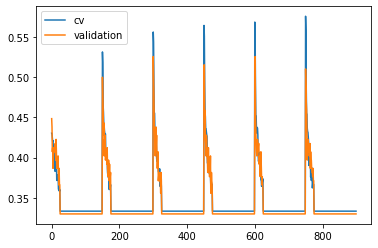

In [81]:
plt.plot(pd.DataFrame(cv.cv_results_)['mean_test_score'])
plt.plot(val)
plt.legend(labels = ['cv', 'validation'])
plt.show()